In [39]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from pathlib import Path

from tqdm.auto import tqdm
from scipy.io import loadmat

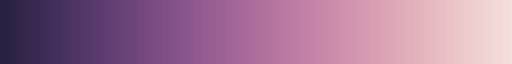

In [40]:
cmap = sns.cubehelix_palette(start=2.9, light=0.9, as_cmap=True, reverse=True)
cmap

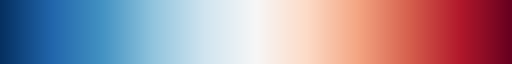

In [41]:
cmap1 = plt.colormaps["RdBu_r"]
cmap1 = cmap1.with_extremes(bad=cmap1(0))
cmap1

In [42]:
example_data_path = Path('./private/saved-data.mat')
package = loadmat(example_data_path)
data = package.get('data')
times = package.get('times')
ch_names = package.get('ch_names')

times = times.squeeze()
ch_names = np.array([e.strip() for e in ch_names])

print(f'Using data: {example_data_path}')
print('It contains', package.keys())
print('data', type(data), data.shape)
print('times', type(times), times.shape)
print('ch_names', type(ch_names), len(ch_names), ch_names)

Using data: private\saved-data.mat
It contains dict_keys(['__header__', '__version__', '__globals__', 'data', 'times', 'ch_names'])
data <class 'numpy.ndarray'> (320, 64, 151)
times <class 'numpy.ndarray'> (151,)
ch_names <class 'numpy.ndarray'> 64 ['FPZ' 'FP1' 'FP2' 'AF3' 'AF4' 'AF7' 'AF8' 'FZ' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'FCZ' 'FC1' 'FC2' 'FC3' 'FC4' 'FC5' 'FC6' 'FT7' 'FT8' 'CZ'
 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'T7' 'T8' 'CP1' 'CP2' 'CP3' 'CP4' 'CP5'
 'CP6' 'TP7' 'TP8' 'PZ' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'POZ' 'PO3' 'PO4'
 'PO5' 'PO6' 'PO7' 'PO8' 'OZ' 'O1' 'O2' 'ECG' 'HEOR' 'HEOL' 'VEOU' 'VEOL']


In [43]:
name = np.array('O1', dtype=ch_names.dtype)
selected_data = data[:, ch_names==name].squeeze()
print(selected_data.shape)

(320, 151)


100%|██████████| 320/320 [00:02<00:00, 141.62it/s]


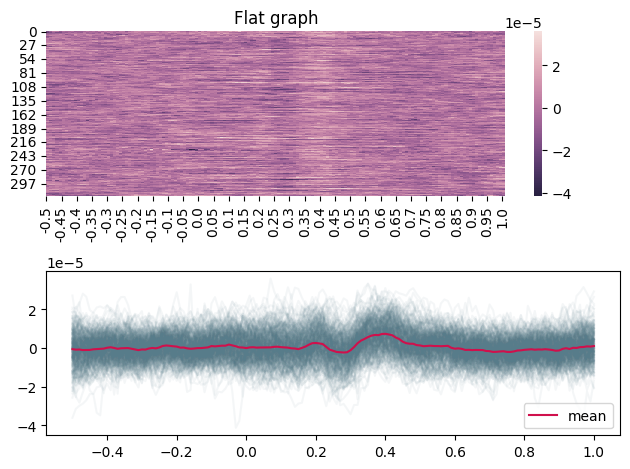

In [44]:
fig, axs = plt.subplots(2, 1)

ax = axs[0]
ax.set_title('Flat graph')
sns.heatmap(selected_data, square=False, cmap=cmap, ax=ax)
ax.set_xticks(range(len(times))[::5], times[::5])

ax = axs[1]
for y in tqdm(selected_data):
    sns.lineplot(x=times, y=y, color='#577C8A10', legend=False, ax=ax)
sns.lineplot(x=times, y=np.mean(selected_data, axis=0), label='mean', color='#D0104C', legend='auto', ax=ax)

fig.tight_layout()
plt.show()

In [45]:
import matplotlib as mpl

mean = np.mean(selected_data, axis=0)
vmax = np.max(mean) * 1.5
vmin = np.min(mean) * 1.5
bins = 100
bins_center = np.linspace(vmin, vmax, bins)
print(f'vmax = {vmax}, vmin = {vmin}, bins = {bins}')

def plot_scores(scores, title='kde score', vmax=vmax, vmin=vmin, bins=bins, cmap=cmap):
    df = pd.DataFrame(scores, columns=times)
    df.index = [f'{e*1e6:0.2f}' for e in bins_center]
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(df, ax=ax, cmap=cmap) #, norm=mpl.colors.LogNorm())
    ax.invert_yaxis()
    sns.scatterplot(x=range(len(times)),y=(mean-vmin)/(vmax-vmin)*bins, color='#33333350', ax=ax)
    sns.lineplot(x=range(len(times)),y=(mean-vmin)/(vmax-vmin)*bins, color='#333333', ax=ax)
    ax.set_title(title)
    fig.tight_layout()
    return fig

vmax = 1.090978915437099e-05, vmin = -3.594386616255278e-06, bins = 100


Computing kde: 100%|██████████| 151/151 [00:00<00:00, 2228.52it/s]

(100, 151)


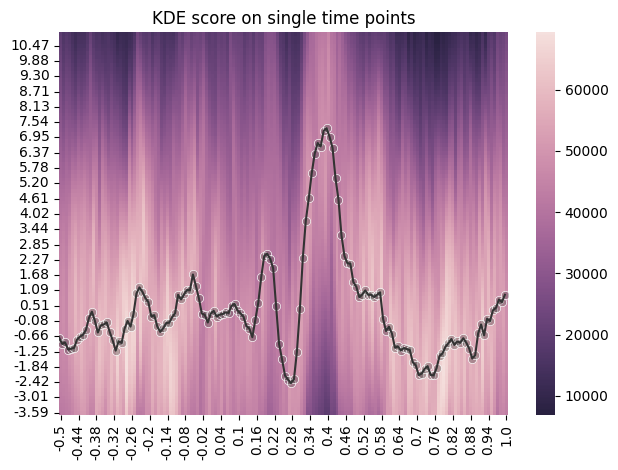

In [46]:
bw_method = 'silverman'
bw_method = 'scott'

'''
Compute kde for every time points
'''

scores = []

for j in tqdm(range(len(times)), 'Computing kde'):
    ts = selected_data[:, j]
    kernel = gaussian_kde(ts, bw_method=bw_method)
    score = kernel(bins_center)
    scores.append(score)

scores = np.array(scores).T
print(scores.shape)

fig = plot_scores(scores, title='KDE score on single time points')
plt.show()

(48320, 2)


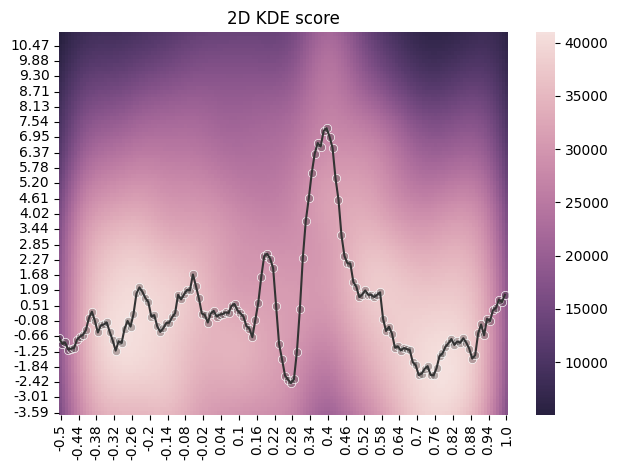

In [47]:
'''
Compute 2D kde
'''
xx, yy = np.meshgrid(times, bins_center)
xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T
xx.shape, xy_sample.shape

expand_times = np.concatenate([times[np.newaxis, :] for _ in range(len(selected_data))])
expand_times.shape
train_data = np.vstack([expand_times.ravel(), selected_data.ravel()]).T
print(train_data.shape)

kernel = gaussian_kde(train_data.T, bw_method=bw_method)
score = kernel(xy_sample.T)
score.shape
resized = score.reshape((100, 151))

fig = plot_scores(resized, title='2D KDE score')
plt.show()

In [48]:
score = kernel(np.vstack([times, mean]))
score_array = [kernel(np.vstack([times, e])) for e in tqdm(selected_data)]
print(np.array(score_array).shape)

100%|██████████| 320/320 [00:15<00:00, 20.60it/s]

(320, 151)


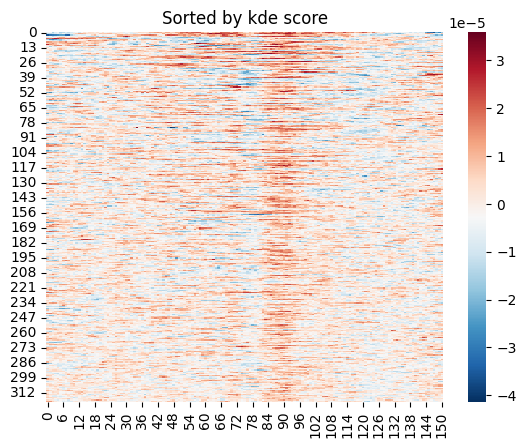

In [49]:
argsort = np.array(np.argsort([np.sum(e) for e in score_array]))
sns.heatmap(selected_data[argsort], cmap=cmap1)
plt.title('Sorted by kde score')
plt.show()

100%|██████████| 320/320 [00:00<00:00, 142815.20it/s]


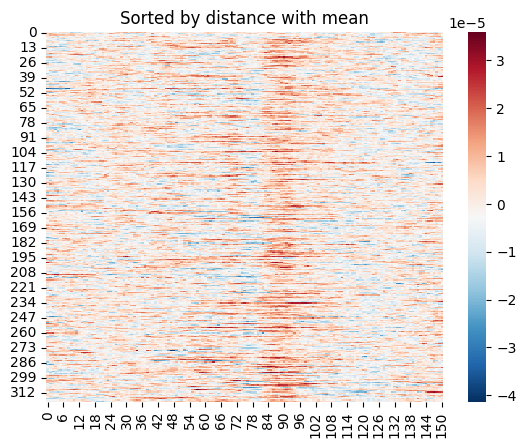

In [50]:
score_array2 = [np.sum(np.power(e-mean, 2)) for e in tqdm(selected_data)][::-1]
argsort2 = np.array(np.argsort([np.sum(e) for e in score_array2]))
sns.heatmap(selected_data[argsort2], cmap=cmap1)
plt.title('Sorted by distance with mean')
plt.show()

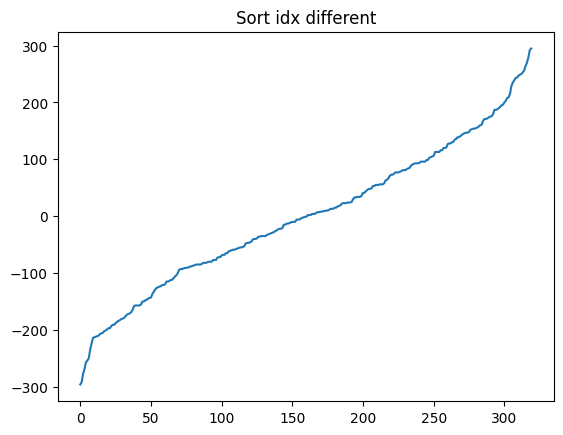

In [56]:
plt.plot(sorted(np.array(argsort) - np.array(argsort2)))
plt.title('Sort idx different')
plt.show()

(151,) (320, 151)
0.036 sec. elapsed
0.037 sec. elapsed


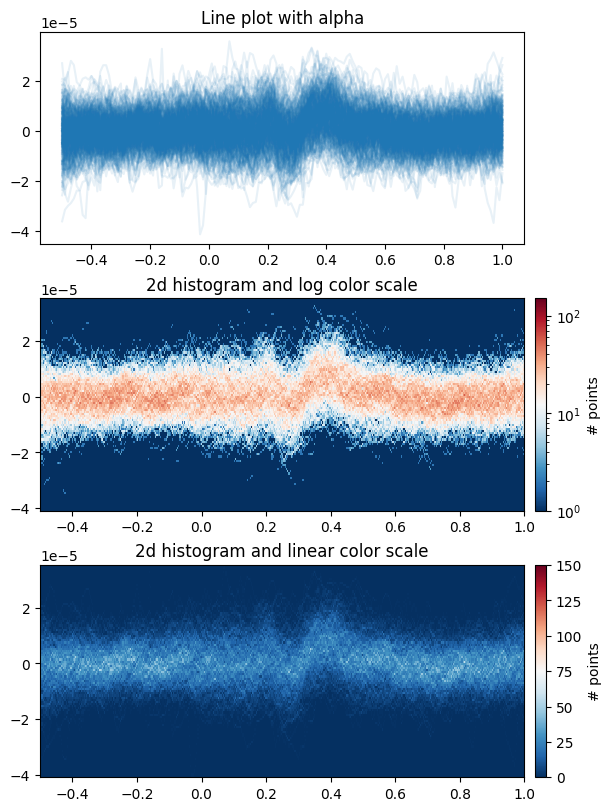

In [51]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')

Y = selected_data
x = times
num_series = len(Y)
print(x.shape, Y.shape)

# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.concatenate([np.interp(x_fine, x, y_row) for y_row in Y])
x_fine = np.broadcast_to(x_fine, (num_series, num_fine)).ravel()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap1,
                         norm="log", vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap1,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()

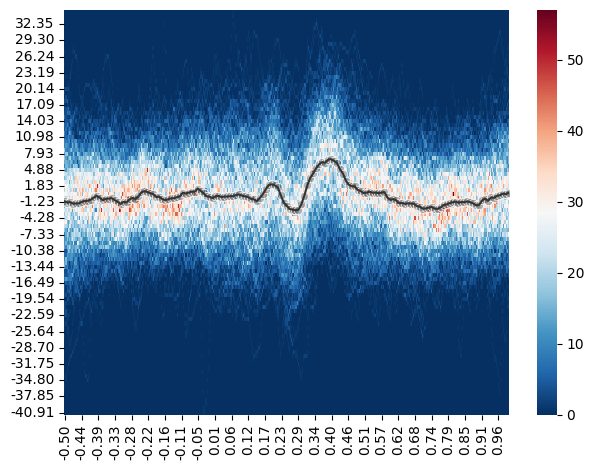

In [52]:
df = pd.DataFrame(h.T, columns=[f'{e:0.2f}' for e in xedges[:-1]])
df.index = [f'{e*1e6:0.2f}' for e in yedges[:-1]]

fig, ax = plt.subplots(1, 1)
sns.heatmap(df, ax=ax, cmap=cmap1)
ax.invert_yaxis()
sns.scatterplot(
    x=np.linspace(0, h.shape[0], 151),
    y=(mean-yedges[0])/(yedges[-1]-yedges[0])*100,
    color='#33333350', ax=ax)
sns.lineplot(
    x=np.linspace(0, h.shape[0], 151),
    y=(mean-yedges[0])/(yedges[-1]-yedges[0])*100,
    color='#333333',
    ax=ax)
fig.tight_layout()
plt.show()